In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder 

from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

As the initial source we have the zip with the txt files already divided into the train and test split. Each file contains the the works of famous authors (Bradberry, Henry, Bulgakov...). Let's extract the zip into a single directory:

In [3]:
!unzip 'drive/My Drive/nn/_4/Тексты писателей-20210525T170220Z-001.zip'

Archive:  drive/My Drive/nn/_4/Тексты писателей-20210525T170220Z-001.zip
replace Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


The txt files' names containt the reference - either it is the train or the test. So let's collect them into the separate lists: one for the all the texts labeled as train, the other one - as test.

In [4]:
def readText(fileName): 
    '''
    collect all the texts
    '''
    f = open(fileName, 'r')
    text = f.read()
    text = text.replace('\n', ' ')

    return text

# define the labels
labels = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nLabels = len(labels)

inputFolder = 'Тексты писателей/'

def collectTexts(inputFolder=inputFolder):
    '''
    collect all texts into the train and test smaples
    '''
    trainText, testText = [], []
    for label in labels:
        for fileName in os.listdir(inputFolder):
            if label in fileName:
                if 'Обучающая' in fileName:
                    trainText.append(readText(inputFolder + fileName))
                    print(f'{fileName} added to the train sample')
                if 'Тестовая' in fileName:
                    testText.append(readText(inputFolder+fileName))
                    print(f'{fileName} added to the test sample')

    return trainText, testText

trainText, testText = collectTexts()

(О. Генри) Тестовая_20 вместе.txt added to the test sample
(О. Генри) Обучающая_50 вместе.txt added to the train sample
(Стругацкие) Обучающая_5 вместе.txt added to the train sample
(Стругацкие) Тестовая_2 вместе.txt added to the test sample
(Булгаков) Тестовая_2 вместе.txt added to the test sample
(Булгаков) Обучающая_5 вместе.txt added to the train sample
(Клиффорд_Саймак) Тестовая_2 вместе.txt added to the test sample
(Клиффорд_Саймак) Обучающая_5 вместе.txt added to the train sample
(Макс Фрай) Тестовая_2 вместе.txt added to the test sample
(Макс Фрай) Обучающая_5 вместе.txt added to the train sample
(Рэй Брэдберри) Обучающая_22 вместе.txt added to the train sample
(Рэй Брэдберри) Тестовая_8 вместе.txt added to the test sample


as the result we have the texts of 6 authors both in train and test samples

In [5]:
print(f'train: {len(trainText)}, test: {len(testText)}')

train: 6, test: 6


To speed up the model fit process and reduce RAM usage we set the up limit of the words to use from the sample:

In [6]:
maxWordsCount = 20000

*The* important step to pass the text to the model is to correctly convert it to the numerics. That can be performed in several steps:

**STEP 1:** word tokenization

We need to split our texts into the single words array and fit the tokenizer based on it.

In [7]:
# all the symbols to exclude from the processed text
symbolsToFilter = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff'

# tensorflow.keras.preprocessing.text
tokenizer = Tokenizer(
    num_words = maxWordsCount, # max words to be processed by the model
    filters = symbolsToFilter,
    lower = True, # enforce the lower register
    split = ' ', # split by space
    oov_token = 'unknown', # replaces all out-of-vocabulary words
    char_level = False # if True, every charcter is used as token
)

tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

Let's check the size of the resulting vocabulary and top 10 frequent words in it:

In [8]:
print(f'top 10 frequent words:\n{items[-10:]}')
print()
print(f'vocabulary size: {len(items)}')

top 10 frequent words:
[('поджарьте', 133061), ('заполните', 133062), ('мучающие', 133063), ('погремушкой', 133064), ('свистком', 133065), ('потерян', 133066), ('расплывающиеся', 133067), ('миллионе', 133068), ('зияющая', 133069), ('ничтонавстречу', 133070)]

vocabulary size: 133070


This is how you can check the index of any word:

In [9]:
# def checkIndex(word=input()):
#     try:
#         return f'index is {tokenizer.word_index[word]} out of {len(items)}'
#     except KeyError:
#         return 'no such word in vocabulary'

# checkIndex()

**STEP 2:** convert tokens into the numeric sequence

We call the *fit_on_sequence* method for our tokenizer:

In [10]:
trainWordIndices = tokenizer.texts_to_sequences(trainText)
testWordIndices = tokenizer.texts_to_sequences(testText)

Let's check the origin and numeric sequence:



In [11]:
print(f'original sequence\n{trainText[2][:80]}')
print(f'numeric sequence\n{trainWordIndices[2][:20]}')

original sequence
﻿Белая гвардия   Посвящается[1]  Любови Евгеньевне Белозерской[2]  Пошел мелкий 
numeric sequence
[2939, 5529, 1, 1508, 1, 1, 16735, 1515, 353, 8296, 1267, 2, 121, 15326, 1, 1, 675, 12013, 10580, 17342]


Now we can extract some statitics based on the results:

In [12]:
myCount = {
    'symbolsInTrain' : 0,
    'wordsInTrain' : 0,
    'symbolsInTest' : 0,
    'wordsInTest' : 0,
}

print('-------------------')
print('TRAIN STATS:')
print('-------------------')
for i in range(nLabels):
    print(
        labels[i], 
        ' ' * (10 - len(labels[i])), 
        len(trainText[i]), 'symbols, ',
        len(trainWordIndices[i]), 'words'
    )
    myCount['symbolsInTrain'] += len(trainText[i])
    myCount['wordsInTrain'] += len(trainWordIndices[i])

print(
    'in total:', 
    ' ' * 1, 
    myCount['symbolsInTrain'], 'symbols, ',
    myCount['wordsInTrain'], 'words'
)
print('-------------------')

print('TEST STATS:')
print('-------------------')
for i in range(nLabels):
    print(
        labels[i], 
        ' ' * (10 - len(labels[i])), 
        len(testText[i]), 'symbols, ',
        len(testWordIndices[i]), 'words'
    )
    myCount['symbolsInTest'] += len(testText[i])
    myCount['wordsInTest'] += len(testWordIndices[i])

print(
    'in total:', 
    ' ' * 1, 
    myCount['symbolsInTest'], 'symbols, ',
    myCount['wordsInTest'], 'words'
)
print('-------------------')

-------------------
TRAIN STATS:
-------------------
О. Генри    1049517 symbols,  160607 words
Стругацкие  2042469 symbols,  313012 words
Булгаков    1765648 symbols,  261465 words
Саймак      1609507 symbols,  251502 words
Фрай        3700010 symbols,  568533 words
Брэдберри   1386454 symbols,  214454 words
in total:   11553605 symbols,  1769573 words
-------------------
TEST STATS:
-------------------
О. Генри    349662 symbols,  53238 words
Стругацкие  704846 symbols,  108621 words
Булгаков    875042 symbols,  132730 words
Саймак      318811 symbols,  50360 words
Фрай        1278191 symbols,  196731 words
Брэдберри   868673 symbols,  132524 words
in total:   4395225 symbols,  674204 words
-------------------


**STEP 3:** Prepare the train and test inputs for the model.

This step implies the following sequence:

1. Get the array of the word indices (*wordIndices*)
2. Cut the sample with the given length (*xLen*)
3. Dump it to the container
4. Take a step from the begining of the previous sample (*step*)

In [13]:
def getSetFromIndices(wordIndices, xLen, step):
    '''
    slice indices of words into the saples of the
    given length (xLen) by the given step
    '''
    xSample = []
    wordsLen = len(wordIndices)
    index = 0

    while (index + xLen <= wordsLen):
        xSample.append(wordIndices[index:index + xLen])
        index += step

    return xSample

def createSetsMultiClasses(wordIndices, xLen, step):
    '''
    prepare both the train and test input for the model 
    '''
    nLabels = len(wordIndices) # get the number of word indices
    classesXSamples = [] 
    for wIdx in wordIndices:
        classesXSamples.append(getSetFromIndices(wIdx, xLen, step))
    # classesXSamples shape:
    # labels count x steps count x steps length (xLen)

    xSamples, ySamples = [], []
    for l in range(nLabels): # for every label
        xL = classesXSamples[l] # collect all the arrays of the respective sample
        for i in range(len(xL)):
            xSamples.append(xL[i]) # dump each array into the features list
            ySamples.append(utils.to_categorical(l, nLabels)) # collect the label as a binary matrix

    xSamples, ySamples = np.array(xSamples), np.array(ySamples)

    return (xSamples, ySamples)

xLen = 1000
step = 100

xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)
print(
    f'the shapes:\nxTrain: {xTrain.shape}, \nxTest: {xTest.shape}',
    f'\nyTest: {yTrain.shape}, \nyTest: {yTest.shape}'
)

the shapes:
xTrain: (17640, 1000), 
xTest: (6686, 1000) 
yTest: (17640, 6), 
yTest: (6686, 6)


Finally we convert the resulting indices into the boolean matrix alike Bag of Words format. This can be performed with method *sequences_to_matrix*:

In [14]:
xTrainB = tokenizer.sequences_to_matrix(xTrain.tolist())
xTestB = tokenizer.sequences_to_matrix(xTest.tolist())

Example of what we get as the output:

In [16]:
print(f'the shape: {xTrainB.shape}')
print('first 100 elements:')
print(xTrainB[0][:100])

the shape: (17640, 20000)
first 100 elements:
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]


Following the preprocessing steps we can dive in the NN model build-up. The model architecture may vary, let's try dense layers with dropout and batchnormalization.

Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 

We will apply *ReLU* as the activation function to the dense layer. The function will output the input directly if it is positive, otherwise, it will output zero. The math formula:

$$ y = max(0, x) $$

As the last activation function we apply *softmax* which take input of N numbers and normalizes it (by applying the standard exponential function) into N probabilites proportional to the exponentials if the input numbers.
Tha math formula:

$$ \sigma(z)_i = \frac{e^{z_i}}{\Sigma^K_{j=1} e^{z_i}} $$

The loss function applied is the cross-entropy loss, or log loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. The math formula:

$$ CE = - \Sigma^C_i t_i*log(s_i) $$  
where:

$ t_i $ is the groundtruth

$ s_i $ is the model prediction

$ i $ is a label

$ C $ is the number of labels

Epoch 1/20
138/138 [==============================] - 4s 11ms/step - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.3757 - val_accuracy: 0.9014
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 3.2180e-04 - accuracy: 1.0000 - val_loss: 0.3087 - val_accuracy: 0.9071
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 1.6304e-04 - accuracy: 1.0000 - val_loss: 0.3019 - val_accuracy: 0.9040
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 1.0192e-04 - accuracy: 1.0000 - val_loss: 0.2999 - val_accuracy: 0.9028
Epoch 5/20
138/138 [==============================] - 1s 8ms/step - loss: 7.9490e-05 - accuracy: 1.0000 - val_loss: 0.3005 - val_accuracy: 0.9017
Epoch 6/20
138/138 [==============================] - 1s 8ms/step - loss: 5.9305e-05 - accuracy: 1.0000 - val_loss: 0.2983 - val_accuracy: 0.9029
Epoch 7/20
138/138 [==============================] - 1s 8ms/step - loss: 4.7021e-05 - accuracy: 1.0000 - val_loss: 0.2966 - va

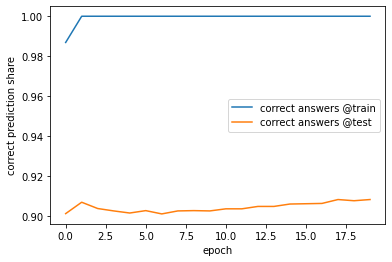

In [17]:
modelD = Sequential()
modelD.add(Dense(
    200, # number of neurons
    input_dim = maxWordsCount, # the input shape must be passed to the 1st stated layer 
    activation='relu' 
))
modelD.add(Dropout(0.25))
modelD.add(BatchNormalization())
modelD.add(Dense(nLabels, activation='softmax'))

modelD.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = modelD.fit(
    xTrainB,
    yTrain,
    epochs=20,
    batch_size=128,
    validation_data = (xTestB, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

Upon model fit we can pass the test samples to validate the accuracy. We can do that in 2 steps:

1. collect the binary matrices for the test sample (similiar to what we have done with the train sample)

2. Pass the matrices into the model for the prediction & check the score

In [18]:
def createTestMultiClasses(wordIndices, xLen, step):
    nLabels = len(wordIndices)
    xTestLabels, xTestLabelsB = [], []
    for wIdx in wordIndices:
        sample = (getSetFromIndices(wIdx, xLen, step))
        xTestLabels.append(sample)
        xTestLabelsB.append(tokenizer.sequences_to_matrix(sample))

    xTestLabels, xTestLabelsB = np.array(xTestLabels, dtype=object), np.array(xTestLabelsB, dtype=object)

    return xTestLabels, xTestLabelsB

def recognizeMultiLabels(model, xTest, modelName):
    print(f'model: {modelName}')

    totalSumRec = 0 # sum up the correct predictions

    for i in range(nLabels):
        currPred = model.predict(xTest[i]) # predict
        currOut = np.argmax(currPred, axis=1) # get the index of the max element

        evVal = []
        for j in range(nLabels): # for every label
            evVal.append(len(currOut[currOut==j]) / len(xTest[i]))
        totalSumRec += len(currOut[currOut==i])
        recognizedLabel = np.argmax(evVal)

        isRecognized = 'false prediction'
        if (recognizedLabel == i):
            isRecognized = 'correct prediction'

        tempStr = 'Label: ' + labels[i] + ' ' * (11 - len(labels[i])) +\
        str(int(100*evVal[i])) + '% the model recognized as ' + labels[recognizedLabel]
        print(tempStr, ' ' * (55 - len(tempStr)), isRecognized, sep ='')

    print()
    sumCount = 0
    for i in range(nLabels):
        sumCount += len(xTest[i])
    print(f'average prediction rate: {int(100*totalSumRec/sumCount)} %')

    return totalSumRec / sumCount

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(modelD, xTestLabelsB, 'Dense')

model: Dense
Label: О. Генри   96% the model recognized as О. Генри correct prediction
Label: Стругацкие 88% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   83% the model recognized as Булгаков correct prediction
Label: Саймак     86% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  96% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %


Let's check what happens if we use not the matrix but the array of the indeces itself. W'll apply the *Embedding* layer which turns positive integers into dense vectors of the fixed size. 

Epoch 1/20
138/138 [==============================] - 3s 18ms/step - loss: 0.7514 - accuracy: 0.7621 - val_loss: 1.6789 - val_accuracy: 0.2966
Epoch 2/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0074 - accuracy: 0.9999 - val_loss: 1.4695 - val_accuracy: 0.3554
Epoch 3/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1821 - val_accuracy: 0.5287
Epoch 4/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.9219 - val_accuracy: 0.6669
Epoch 5/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.8549 - val_accuracy: 0.7039
Epoch 6/20
138/138 [==============================] - 2s 16ms/step - loss: 9.3270e-04 - accuracy: 1.0000 - val_loss: 0.8599 - val_accuracy: 0.7121
Epoch 7/20
138/138 [==============================] - 2s 16ms/step - loss: 7.3852e-04 - accuracy: 1.0000 - val_loss: 0.8651 - val_accuracy

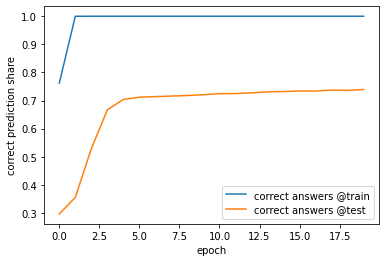

In [19]:
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 20, input_length=xLen))
modelE.add(Dropout(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation='relu'))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = modelE.fit(
    xTrain, yTrain,
    epochs = 20,
    batch_size = 128,
    validation_data = (xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

In [20]:
xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(modelE, xTestLabels, 'Dense')

model: Dense
Label: О. Генри   88% the model recognized as О. Генри correct prediction
Label: Стругацкие 75% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   59% the model recognized as Булгаков correct prediction
Label: Саймак     71% the model recognized as Саймак   correct prediction
Label: Фрай       82% the model recognized as Фрай     correct prediction
Label: Брэдберри  70% the model recognized as Брэдберриcorrect prediction

average prediction rate: 73 %


The prediction rate dropped significantly.

In general, the text processing can be drawn as follows:
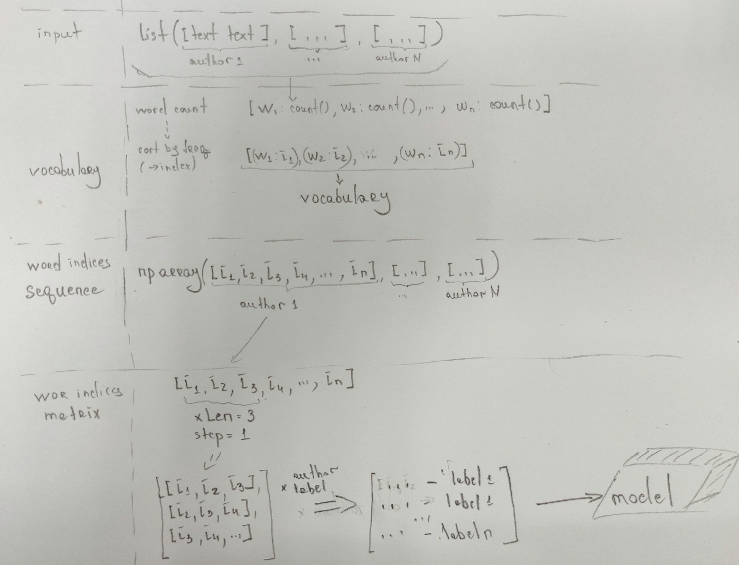

Now let's try to improve the model score. We can either 

* search for the optimal hyperparameters or 
* experiment with the parameters of the text preparation step

Epoch 1/20
138/138 [==============================] - 1s 5ms/step - loss: 1.1978 - accuracy: 0.5567 - val_loss: 1.2694 - val_accuracy: 0.5311
Epoch 2/20
138/138 [==============================] - 1s 4ms/step - loss: 0.8356 - accuracy: 0.6908 - val_loss: 1.2361 - val_accuracy: 0.5413
Epoch 3/20
138/138 [==============================] - 0s 4ms/step - loss: 0.7367 - accuracy: 0.7267 - val_loss: 1.2856 - val_accuracy: 0.5266
Epoch 4/20
138/138 [==============================] - 0s 4ms/step - loss: 0.6563 - accuracy: 0.7623 - val_loss: 1.3506 - val_accuracy: 0.5224
Epoch 5/20
138/138 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.7828 - val_loss: 1.3802 - val_accuracy: 0.5323
Epoch 6/20
138/138 [==============================] - 0s 4ms/step - loss: 0.5471 - accuracy: 0.8011 - val_loss: 1.4782 - val_accuracy: 0.5145
Epoch 7/20
138/138 [==============================] - 1s 4ms/step - loss: 0.4983 - accuracy: 0.8179 - val_loss: 1.6813 - val_accuracy: 0.4838
Epoch 

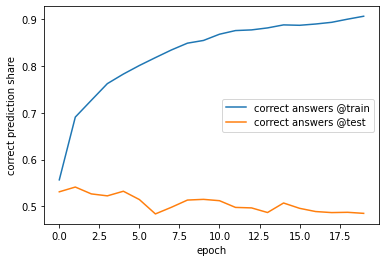

model: Dense
Label: О. Генри   45% the model recognized as О. Генри correct prediction
Label: Стругацкие 52% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   47% the model recognized as Булгаков correct prediction
Label: Саймак     39% the model recognized as Саймак   correct prediction
Label: Фрай       64% the model recognized as Фрай     correct prediction
Label: Брэдберри  28% the model recognized as Стругацкиеfalse prediction

average prediction rate: 48 %
Epoch 1/20
138/138 [==============================] - 1s 5ms/step - loss: 0.2204 - accuracy: 0.9337 - val_loss: 0.5199 - val_accuracy: 0.8359
Epoch 2/20
138/138 [==============================] - 1s 4ms/step - loss: 0.0111 - accuracy: 0.9995 - val_loss: 0.4588 - val_accuracy: 0.8430
Epoch 3/20
138/138 [==============================] - 1s 4ms/step - loss: 0.0053 - accuracy: 0.9999 - val_loss: 0.4630 - val_accuracy: 0.8403
Epoch 4/20
138/138 [==============================] - 1s 4ms/step - loss: 0.0028 - acc

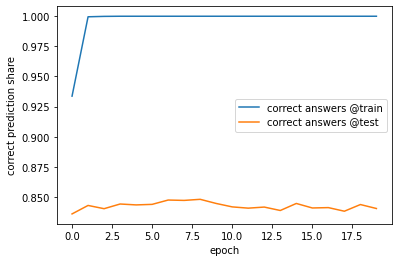

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 80% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   82% the model recognized as Булгаков correct prediction
Label: Саймак     71% the model recognized as Саймак   correct prediction
Label: Фрай       89% the model recognized as Фрай     correct prediction
Label: Брэдберри  80% the model recognized as Брэдберриcorrect prediction

average prediction rate: 84 %
Epoch 1/20
138/138 [==============================] - 2s 7ms/step - loss: 0.0585 - accuracy: 0.9820 - val_loss: 0.4259 - val_accuracy: 0.8741
Epoch 2/20
138/138 [==============================] - 1s 6ms/step - loss: 6.6302e-04 - accuracy: 1.0000 - val_loss: 0.3564 - val_accuracy: 0.8871
Epoch 3/20
138/138 [==============================] - 1s 6ms/step - loss: 3.3346e-04 - accuracy: 1.0000 - val_loss: 0.3401 - val_accuracy: 0.8892
Epoch 4/20
138/138 [==============================] - 1s 6ms/step - loss: 2.2

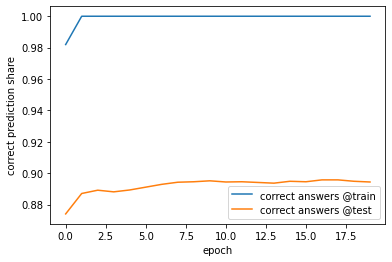

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 88% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   84% the model recognized as Булгаков correct prediction
Label: Саймак     81% the model recognized as Саймак   correct prediction
Label: Фрай       89% the model recognized as Фрай     correct prediction
Label: Брэдберри  96% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 3s 19ms/step - loss: 0.0400 - accuracy: 0.9883 - val_loss: 0.4268 - val_accuracy: 0.8738
Epoch 2/20
138/138 [==============================] - 2s 15ms/step - loss: 2.0423e-04 - accuracy: 1.0000 - val_loss: 0.3735 - val_accuracy: 0.8762
Epoch 3/20
138/138 [==============================] - 2s 15ms/step - loss: 9.3359e-05 - accuracy: 1.0000 - val_loss: 0.3646 - val_accuracy: 0.8754
Epoch 4/20
138/138 [==============================] - 2s 15ms/step - loss:

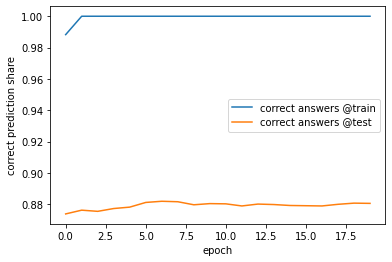

model: Dense
Label: О. Генри   92% the model recognized as О. Генри correct prediction
Label: Стругацкие 86% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   80% the model recognized as Булгаков correct prediction
Label: Саймак     71% the model recognized as Саймак   correct prediction
Label: Фрай       89% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 88 %
{100: 0.48504337421477717, 1000: 0.8404128028716722, 10000: 0.8944062219563267, 50000: 0.8804965599760693}


In [ ]:
maxWordsCounts = [100, 1000, 10000, 50000]

globHist = {}

for maxWordsCount in maxWordsCounts:

    maxWordsCount = maxWordsCount

    # DATA PROCESSING

    tokenizer = Tokenizer(
        num_words = maxWordsCount, # max words to be processed by the model
        filters = symbolsToFilter,
        lower = True, # enforce the lower register
        split = ' ', # split by space
        oov_token = 'unknown', # replaces all out-of-vocabulary words
        char_level = False # if True, every charcter is used as token
    )

    tokenizer.fit_on_texts(trainText)

    trainWordIndices = tokenizer.texts_to_sequences(trainText)
    testWordIndices = tokenizer.texts_to_sequences(testText)

    xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
    xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)

    xTrainB = tokenizer.sequences_to_matrix(xTrain.tolist())
    xTestB = tokenizer.sequences_to_matrix(xTest.tolist())

    # MODEL FIT

    modelD = Sequential()
    modelD.add(Dense(
        200, # number of neurons
        input_dim = maxWordsCount, # the input shape must be passed to the 1st stated layer 
        activation='relu' 
    ))
    modelD.add(Dropout(0.25))
    modelD.add(BatchNormalization())
    modelD.add(Dense(nLabels, activation='softmax'))

    modelD.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = modelD.fit(
        xTrainB,
        yTrain,
        epochs=20,
        batch_size=128,
        validation_data = (xTestB, yTest)
    )

    plt.plot(history.history['accuracy'], label='correct answers @train')
    plt.plot(history.history['val_accuracy'], label='correct answers @test')
    plt.xlabel('epoch')
    plt.ylabel('correct prediction share')
    plt.legend()
    plt.show()

    # PREDICTION

    xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
    pred = recognizeMultiLabels(modelD, xTestLabelsB, 'Dense')

    globHist[maxWordsCount] = pred

print(globHist)

In [ ]:
print(globHist)

{100: 0.48504337421477717, 1000: 0.8404128028716722, 10000: 0.8944062219563267, 50000: 0.8804965599760693}


Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0983 - accuracy: 0.9774 - val_loss: 0.4424 - val_accuracy: 0.9019
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0057 - accuracy: 0.9999 - val_loss: 0.3576 - val_accuracy: 0.9044
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3282 - val_accuracy: 0.9079
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3354 - val_accuracy: 0.8984
Epoch 5/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3128 - val_accuracy: 0.9077
Epoch 6/20
138/138 [==============================] - 1s 8ms/step - loss: 9.6442e-04 - accuracy: 1.0000 - val_loss: 0.3078 - val_accuracy: 0.9050
Epoch 7/20
138/138 [==============================] - 1s 8ms/step - loss: 7.0463e-04 - accuracy: 1.0000 - val_loss: 0.3028 - val_accuracy: 0.90

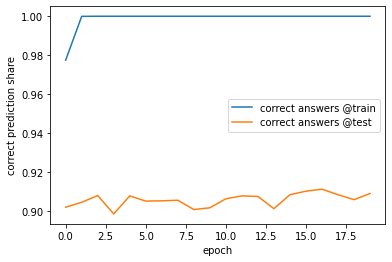

model: Dense
Label: О. Генри   96% the model recognized as О. Генри correct prediction
Label: Стругацкие 85% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   86% the model recognized as Булгаков correct prediction
Label: Саймак     81% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.1685 - accuracy: 0.9518 - val_loss: 0.9194 - val_accuracy: 0.9260
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0110 - accuracy: 0.9999 - val_loss: 0.5787 - val_accuracy: 0.9170
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.4174 - val_accuracy: 0.9168
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0034 - a

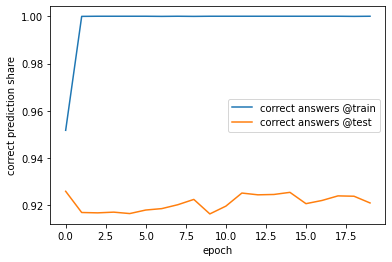

model: Dense
Label: О. Генри   98% the model recognized as О. Генри correct prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   83% the model recognized as Булгаков correct prediction
Label: Саймак     88% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 92 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0654 - accuracy: 0.9816 - val_loss: 0.4202 - val_accuracy: 0.9049
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3836 - val_accuracy: 0.8926
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3675 - val_accuracy: 0.8917
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 9.5312e-04

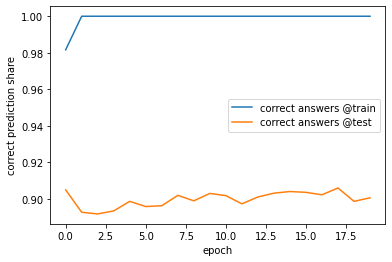

model: Dense
Label: О. Генри   95% the model recognized as О. Генри correct prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   85% the model recognized as Булгаков correct prediction
Label: Саймак     86% the model recognized as Саймак   correct prediction
Label: Фрай       83% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.1606 - accuracy: 0.9634 - val_loss: 0.5128 - val_accuracy: 0.8833
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.4064 - val_accuracy: 0.8860
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.8920
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0033 - a

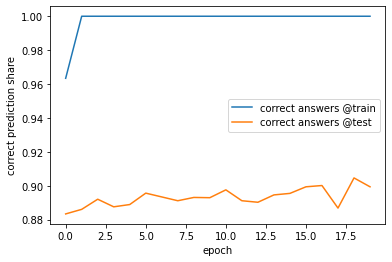

model: Dense
Label: О. Генри   92% the model recognized as О. Генри correct prediction
Label: Стругацкие 90% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   86% the model recognized as Булгаков correct prediction
Label: Саймак     81% the model recognized as Саймак   correct prediction
Label: Фрай       87% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.4443 - accuracy: 0.8596 - val_loss: 0.8147 - val_accuracy: 0.8792
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0247 - accuracy: 0.9991 - val_loss: 0.4809 - val_accuracy: 0.8998
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0108 - accuracy: 0.9998 - val_loss: 0.3575 - val_accuracy: 0.9047
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0070 - a

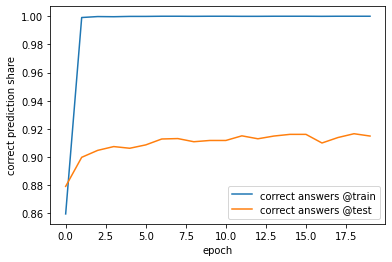

model: Dense
Label: О. Генри   95% the model recognized as О. Генри correct prediction
Label: Стругацкие 88% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   85% the model recognized as Булгаков correct prediction
Label: Саймак     85% the model recognized as Саймак   correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 91 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0803 - accuracy: 0.9812 - val_loss: 0.4140 - val_accuracy: 0.8993
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.3574 - val_accuracy: 0.9014
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3479 - val_accuracy: 0.8978
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0011 - a

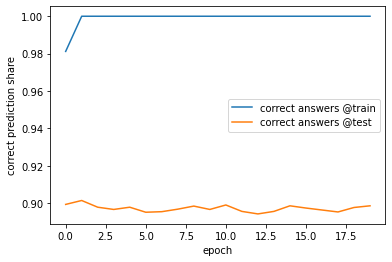

model: Dense
Label: О. Генри   98% the model recognized as О. Генри correct prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   86% the model recognized as Булгаков correct prediction
Label: Саймак     87% the model recognized as Саймак   correct prediction
Label: Фрай       82% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.2021 - accuracy: 0.9489 - val_loss: 0.5681 - val_accuracy: 0.8899
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.3857 - val_accuracy: 0.8913
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.3280 - val_accuracy: 0.8981
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0039 - a

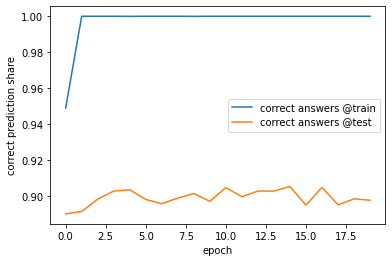

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 90% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   82% the model recognized as Булгаков correct prediction
Label: Саймак     75% the model recognized as Саймак   correct prediction
Label: Фрай       90% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.7372 - accuracy: 0.7518 - val_loss: 1.0083 - val_accuracy: 0.7703
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 0.0435 - accuracy: 0.9980 - val_loss: 0.5429 - val_accuracy: 0.8836
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0165 - accuracy: 0.9995 - val_loss: 0.3063 - val_accuracy: 0.9161
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0091 - a

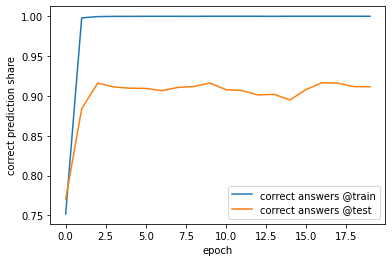

model: Dense
Label: О. Генри   97% the model recognized as О. Генри correct prediction
Label: Стругацкие 85% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   86% the model recognized as Булгаков correct prediction
Label: Саймак     84% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 91 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0809 - accuracy: 0.9798 - val_loss: 0.4100 - val_accuracy: 0.8892
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3544 - val_accuracy: 0.8880
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3609 - val_accuracy: 0.8845
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0011 - a

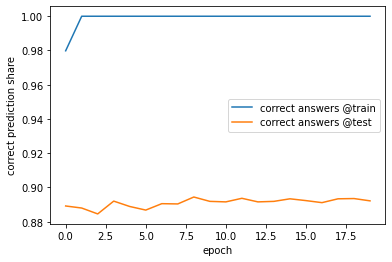

model: Dense
Label: О. Генри   97% the model recognized as О. Генри correct prediction
Label: Стругацкие 88% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   83% the model recognized as Булгаков correct prediction
Label: Саймак     84% the model recognized as Саймак   correct prediction
Label: Фрай       86% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0485 - accuracy: 0.9853 - val_loss: 0.4055 - val_accuracy: 0.8832
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 3.4621e-04 - accuracy: 1.0000 - val_loss: 0.3602 - val_accuracy: 0.8856
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 1.7380e-04 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.8847
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 1.

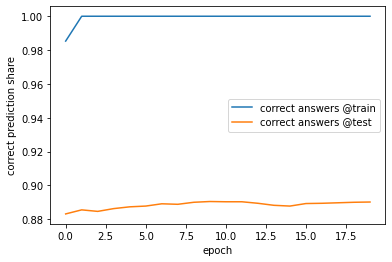

model: Dense
Label: О. Генри   92% the model recognized as О. Генри correct prediction
Label: Стругацкие 90% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   76% the model recognized as Булгаков correct prediction
Label: Саймак     80% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0800 - accuracy: 0.9736 - val_loss: 0.6283 - val_accuracy: 0.8884
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 8.4275e-04 - accuracy: 1.0000 - val_loss: 0.4043 - val_accuracy: 0.9116
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 4.3021e-04 - accuracy: 1.0000 - val_loss: 0.3224 - val_accuracy: 0.9116
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 3.

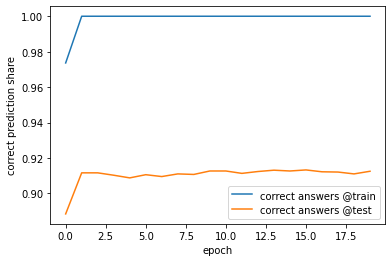

model: Dense
Label: О. Генри   95% the model recognized as О. Генри correct prediction
Label: Стругацкие 92% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   83% the model recognized as Булгаков correct prediction
Label: Саймак     93% the model recognized as Саймак   correct prediction
Label: Фрай       88% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 91 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0357 - accuracy: 0.9896 - val_loss: 0.3701 - val_accuracy: 0.8812
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 1.8884e-04 - accuracy: 1.0000 - val_loss: 0.3435 - val_accuracy: 0.8898
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 9.7580e-05 - accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.8920
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 6.

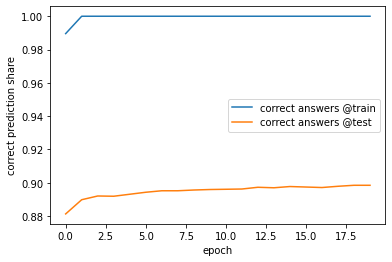

model: Dense
Label: О. Генри   96% the model recognized as О. Генри correct prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   75% the model recognized as Булгаков correct prediction
Label: Саймак     86% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0653 - accuracy: 0.9809 - val_loss: 0.3816 - val_accuracy: 0.8987
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 6.6173e-04 - accuracy: 1.0000 - val_loss: 0.3321 - val_accuracy: 0.8968
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 3.3433e-04 - accuracy: 1.0000 - val_loss: 0.3205 - val_accuracy: 0.8955
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 2.

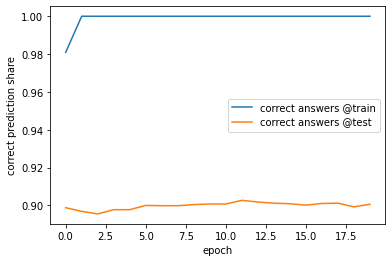

model: Dense
Label: О. Генри   95% the model recognized as О. Генри correct prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   80% the model recognized as Булгаков correct prediction
Label: Саймак     80% the model recognized as Саймак   correct prediction
Label: Фрай       90% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.1614 - accuracy: 0.9468 - val_loss: 0.6541 - val_accuracy: 0.8926
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 8.6430e-04 - accuracy: 1.0000 - val_loss: 0.3890 - val_accuracy: 0.9224
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 4.8576e-04 - accuracy: 1.0000 - val_loss: 0.2990 - val_accuracy: 0.9209
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 3.

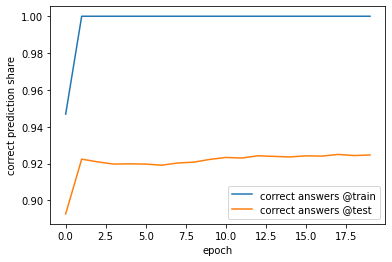

model: Dense
Label: О. Генри   96% the model recognized as О. Генри correct prediction
Label: Стругацкие 91% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   88% the model recognized as Булгаков correct prediction
Label: Саймак     90% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 92 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0374 - accuracy: 0.9882 - val_loss: 0.3513 - val_accuracy: 0.8748
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 1.9417e-04 - accuracy: 1.0000 - val_loss: 0.3238 - val_accuracy: 0.8839
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 1.1076e-04 - accuracy: 1.0000 - val_loss: 0.3204 - val_accuracy: 0.8847
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 7.

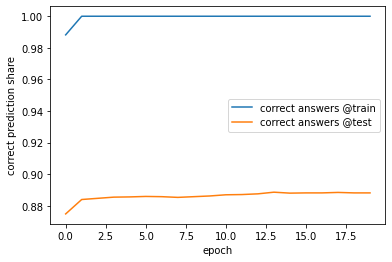

model: Dense
Label: О. Генри   92% the model recognized as О. Генри correct prediction
Label: Стругацкие 91% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   76% the model recognized as Булгаков correct prediction
Label: Саймак     82% the model recognized as Саймак   correct prediction
Label: Фрай       90% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 88 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0681 - accuracy: 0.9793 - val_loss: 0.4782 - val_accuracy: 0.8591
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 5.4802e-04 - accuracy: 1.0000 - val_loss: 0.3726 - val_accuracy: 0.8774
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 2.8595e-04 - accuracy: 1.0000 - val_loss: 0.3586 - val_accuracy: 0.8771
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 1.

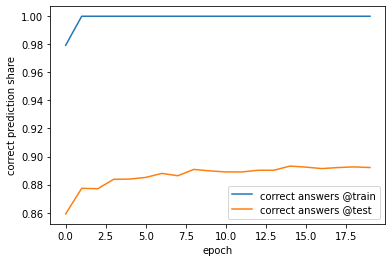

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 90% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   77% the model recognized as Булгаков correct prediction
Label: Саймак     85% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  95% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.2520 - accuracy: 0.9130 - val_loss: 0.7265 - val_accuracy: 0.8690
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 7.6634e-04 - accuracy: 1.0000 - val_loss: 0.4197 - val_accuracy: 0.8996
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 4.7650e-04 - accuracy: 1.0000 - val_loss: 0.3196 - val_accuracy: 0.9019
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 2.

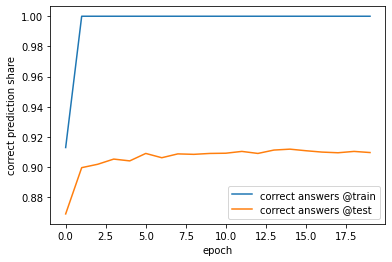

model: Dense
Label: О. Генри   97% the model recognized as О. Генри correct prediction
Label: Стругацкие 89% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   81% the model recognized as Булгаков correct prediction
Label: Саймак     86% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0389 - accuracy: 0.9873 - val_loss: 0.3381 - val_accuracy: 0.8778
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 1.4406e-04 - accuracy: 1.0000 - val_loss: 0.3076 - val_accuracy: 0.8904
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 7.9004e-05 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.8920
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 5.

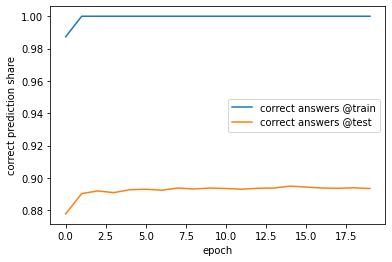

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 87% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   81% the model recognized as Булгаков correct prediction
Label: Саймак     80% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.3764 - val_accuracy: 0.8880
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 9.1706e-05 - accuracy: 1.0000 - val_loss: 0.3402 - val_accuracy: 0.8871
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 4.7256e-05 - accuracy: 1.0000 - val_loss: 0.3395 - val_accuracy: 0.8865
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 2.

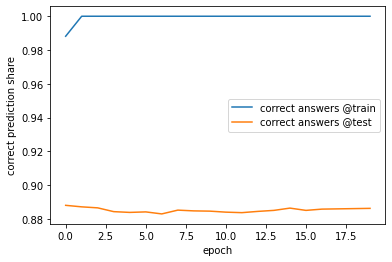

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 85% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   76% the model recognized as Булгаков correct prediction
Label: Саймак     84% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 88 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0583 - accuracy: 0.9812 - val_loss: 0.4546 - val_accuracy: 0.8748
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 1.9884e-04 - accuracy: 1.0000 - val_loss: 0.3193 - val_accuracy: 0.9013
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 1.0226e-04 - accuracy: 1.0000 - val_loss: 0.3023 - val_accuracy: 0.9043
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 6.

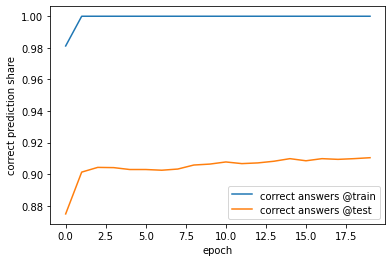

model: Dense
Label: О. Генри   97% the model recognized as О. Генри correct prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   82% the model recognized as Булгаков correct prediction
Label: Саймак     87% the model recognized as Саймак   correct prediction
Label: Фрай       88% the model recognized as Фрай     correct prediction
Label: Брэдберри  99% the model recognized as Брэдберриcorrect prediction

average prediction rate: 91 %
Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 0.4343 - val_accuracy: 0.8518
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 1.1698e-04 - accuracy: 1.0000 - val_loss: 0.4288 - val_accuracy: 0.8561
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 4.6625e-05 - accuracy: 1.0000 - val_loss: 0.4482 - val_accuracy: 0.8540
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 2.

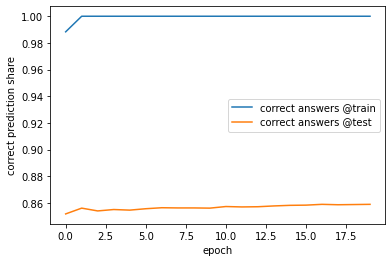

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 77% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   68% the model recognized as Булгаков correct prediction
Label: Саймак     86% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 85 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0390 - accuracy: 0.9878 - val_loss: 0.3786 - val_accuracy: 0.8715
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 9.4021e-05 - accuracy: 1.0000 - val_loss: 0.3361 - val_accuracy: 0.8809
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 4.9548e-05 - accuracy: 1.0000 - val_loss: 0.3330 - val_accuracy: 0.8818
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 3.

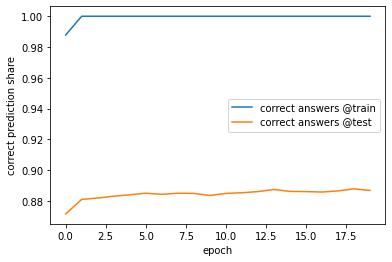

model: Dense
Label: О. Генри   90% the model recognized as О. Генри correct prediction
Label: Стругацкие 83% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   80% the model recognized as Булгаков correct prediction
Label: Саймак     84% the model recognized as Саймак   correct prediction
Label: Фрай       90% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 88 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0945 - accuracy: 0.9667 - val_loss: 0.6279 - val_accuracy: 0.8585
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 1.0984e-04 - accuracy: 1.0000 - val_loss: 0.3670 - val_accuracy: 0.8981
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 4.8188e-05 - accuracy: 1.0000 - val_loss: 0.2983 - val_accuracy: 0.8995
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 3.

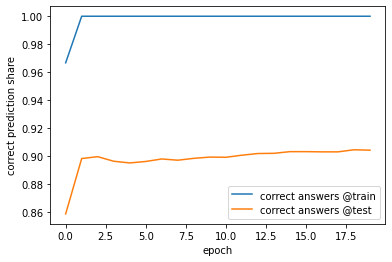

model: Dense
Label: О. Генри   96% the model recognized as О. Генри correct prediction
Label: Стругацкие 89% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   84% the model recognized as Булгаков correct prediction
Label: Саймак     83% the model recognized as Саймак   correct prediction
Label: Фрай       89% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0333 - accuracy: 0.9894 - val_loss: 0.5010 - val_accuracy: 0.8317
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 5.0676e-05 - accuracy: 1.0000 - val_loss: 0.4804 - val_accuracy: 0.8473
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 2.6869e-05 - accuracy: 1.0000 - val_loss: 0.4908 - val_accuracy: 0.8471
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 1.

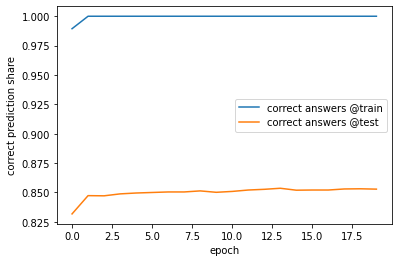

model: Dense
Label: О. Генри   89% the model recognized as О. Генри correct prediction
Label: Стругацкие 80% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   68% the model recognized as Булгаков correct prediction
Label: Саймак     71% the model recognized as Саймак   correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  95% the model recognized as Брэдберриcorrect prediction

average prediction rate: 85 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0460 - accuracy: 0.9841 - val_loss: 0.3006 - val_accuracy: 0.9059
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 8.0486e-05 - accuracy: 1.0000 - val_loss: 0.2748 - val_accuracy: 0.9028
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 3.9623e-05 - accuracy: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9020
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 2.

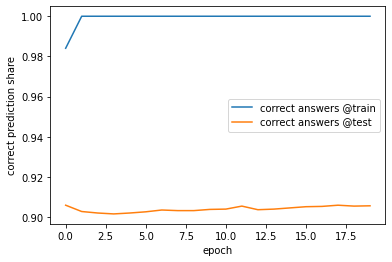

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 87% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   83% the model recognized as Булгаков correct prediction
Label: Саймак     80% the model recognized as Саймак   correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  95% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 13ms/step - loss: 0.1342 - accuracy: 0.9526 - val_loss: 0.6147 - val_accuracy: 0.8503
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 5.2838e-05 - accuracy: 1.0000 - val_loss: 0.3535 - val_accuracy: 0.8920
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 2.8694e-05 - accuracy: 1.0000 - val_loss: 0.2892 - val_accuracy: 0.8956
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 1.

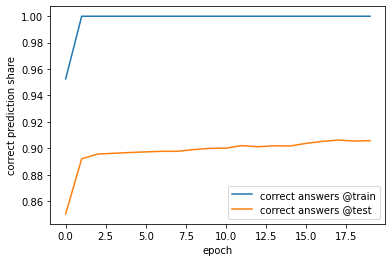

model: Dense
Label: О. Генри   95% the model recognized as О. Генри correct prediction
Label: Стругацкие 82% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   87% the model recognized as Булгаков correct prediction
Label: Саймак     82% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  98% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.4979 - val_accuracy: 0.8436
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 2.1372e-05 - accuracy: 1.0000 - val_loss: 0.4794 - val_accuracy: 0.8575
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 1.0715e-05 - accuracy: 1.0000 - val_loss: 0.4761 - val_accuracy: 0.8614
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 6.

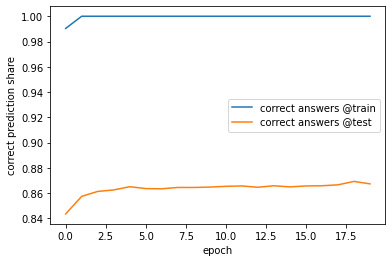

model: Dense
Label: О. Генри   88% the model recognized as О. Генри correct prediction
Label: Стругацкие 80% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   76% the model recognized as Булгаков correct prediction
Label: Саймак     70% the model recognized as Саймак   correct prediction
Label: Фрай       95% the model recognized as Фрай     correct prediction
Label: Брэдберри  94% the model recognized as Брэдберриcorrect prediction

average prediction rate: 86 %
Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0336 - accuracy: 0.9893 - val_loss: 0.4311 - val_accuracy: 0.8445
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 4.9044e-05 - accuracy: 1.0000 - val_loss: 0.4572 - val_accuracy: 0.8409
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 2.1260e-05 - accuracy: 1.0000 - val_loss: 0.4828 - val_accuracy: 0.8371
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 1.

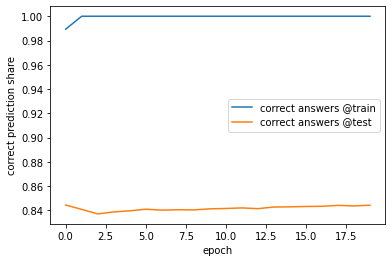

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 72% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   66% the model recognized as Булгаков correct prediction
Label: Саймак     78% the model recognized as Саймак   correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  96% the model recognized as Брэдберриcorrect prediction

average prediction rate: 84 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0475 - accuracy: 0.9848 - val_loss: 0.4404 - val_accuracy: 0.8570
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 1.2042e-04 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.8853
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 4.3247e-05 - accuracy: 1.0000 - val_loss: 0.3193 - val_accuracy: 0.8920
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 3

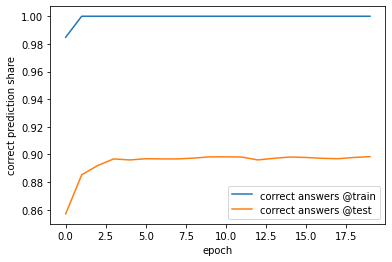

model: Dense
Label: О. Генри   95% the model recognized as О. Генри correct prediction
Label: Стругацкие 86% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   83% the model recognized as Булгаков correct prediction
Label: Саймак     78% the model recognized as Саймак   correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 89 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 0.8070 - val_accuracy: 0.7770
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 4.6674e-05 - accuracy: 1.0000 - val_loss: 0.7815 - val_accuracy: 0.7949
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 2.5879e-05 - accuracy: 1.0000 - val_loss: 0.7794 - val_accuracy: 0.8026
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 1.

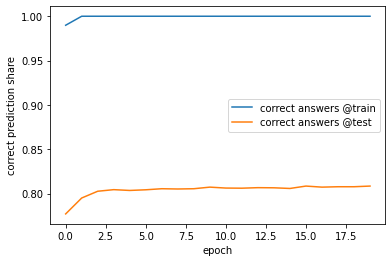

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 79% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   51% the model recognized as Булгаков correct prediction
Label: Саймак     76% the model recognized as Саймак   correct prediction
Label: Фрай       88% the model recognized as Фрай     correct prediction
Label: Брэдберри  96% the model recognized as Брэдберриcorrect prediction

average prediction rate: 80 %
Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0322 - accuracy: 0.9895 - val_loss: 0.4211 - val_accuracy: 0.8518
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 4.2969e-05 - accuracy: 1.0000 - val_loss: 0.4215 - val_accuracy: 0.8528
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 2.2465e-05 - accuracy: 1.0000 - val_loss: 0.4170 - val_accuracy: 0.8573
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss:

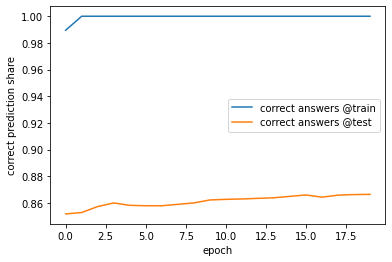

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 82% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   70% the model recognized as Булгаков correct prediction
Label: Саймак     74% the model recognized as Саймак   correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 86 %
Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 0.0712 - accuracy: 0.9753 - val_loss: 0.6053 - val_accuracy: 0.8527
Epoch 2/20
138/138 [==============================] - 1s 9ms/step - loss: 2.7555e-05 - accuracy: 1.0000 - val_loss: 0.3374 - val_accuracy: 0.9028
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 1.6403e-05 - accuracy: 1.0000 - val_loss: 0.2746 - val_accuracy: 0.9055
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 9

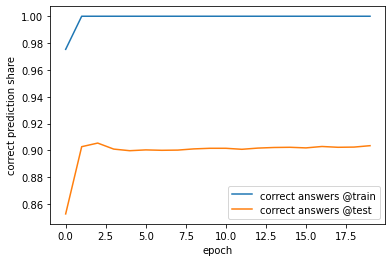

model: Dense
Label: О. Генри   94% the model recognized as О. Генри correct prediction
Label: Стругацкие 79% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   85% the model recognized as Булгаков correct prediction
Label: Саймак     89% the model recognized as Саймак   correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 90 %
Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0323 - accuracy: 0.9899 - val_loss: 0.5467 - val_accuracy: 0.8377
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 2.8238e-05 - accuracy: 1.0000 - val_loss: 0.5704 - val_accuracy: 0.8462
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 1.4511e-05 - accuracy: 1.0000 - val_loss: 0.6201 - val_accuracy: 0.8421
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 

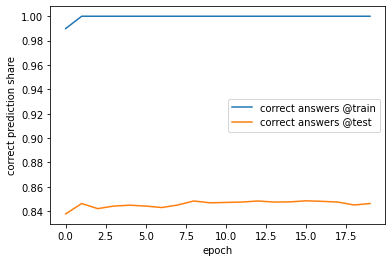

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 72% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   78% the model recognized as Булгаков correct prediction
Label: Саймак     67% the model recognized as Саймак   correct prediction
Label: Фрай       90% the model recognized as Фрай     correct prediction
Label: Брэдберри  93% the model recognized as Брэдберриcorrect prediction

average prediction rate: 84 %
Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0358 - accuracy: 0.9882 - val_loss: 0.3944 - val_accuracy: 0.8633
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 1.9678e-05 - accuracy: 1.0000 - val_loss: 0.5318 - val_accuracy: 0.8198
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 4.4980e-06 - accuracy: 1.0000 - val_loss: 0.5205 - val_accuracy: 0.8341
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss:

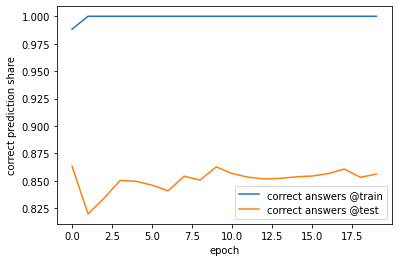

model: Dense
Label: О. Генри   86% the model recognized as О. Генри correct prediction
Label: Стругацкие 74% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   73% the model recognized as Булгаков correct prediction
Label: Саймак     76% the model recognized as Саймак   correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  95% the model recognized as Брэдберриcorrect prediction

average prediction rate: 85 %
Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0949 - accuracy: 0.9667 - val_loss: 0.4889 - val_accuracy: 0.8709
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 1.2930e-05 - accuracy: 1.0000 - val_loss: 0.2844 - val_accuracy: 0.9094
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 7.0317e-06 - accuracy: 1.0000 - val_loss: 0.2737 - val_accuracy: 0.9061
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss:

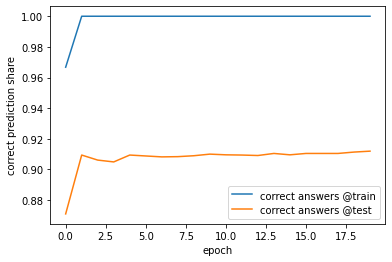

model: Dense
Label: О. Генри   92% the model recognized as О. Генри correct prediction
Label: Стругацкие 81% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   90% the model recognized as Булгаков correct prediction
Label: Саймак     88% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  97% the model recognized as Брэдберриcorrect prediction

average prediction rate: 91 %
Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0333 - accuracy: 0.9890 - val_loss: 1.1465 - val_accuracy: 0.7770
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 3.8075e-05 - accuracy: 1.0000 - val_loss: 0.7630 - val_accuracy: 0.8486
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 9.5975e-06 - accuracy: 1.0000 - val_loss: 0.7891 - val_accuracy: 0.8398
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss:

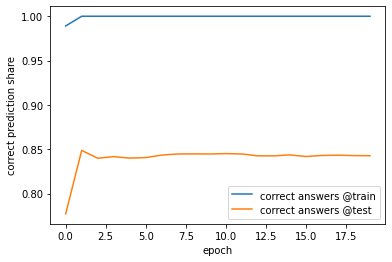

model: Dense
Label: О. Генри   93% the model recognized as О. Генри correct prediction
Label: Стругацкие 69% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   78% the model recognized as Булгаков correct prediction
Label: Саймак     62% the model recognized as Саймак   correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  91% the model recognized as Брэдберриcorrect prediction

average prediction rate: 84 %
{(50, 1, 'relu'): 0.9089141489679928, (50, 1, 'sigmoid'): 0.9210290158540233, (50, 1, 'tanh'): 0.900538438528268, (50, 2, 'relu'): 0.8993419084654501, (50, 2, 'sigmoid'): 0.914896799282082, (50, 2, 'tanh'): 0.898594077176189, (50, 3, 'relu'): 0.8975471133712235, (50, 3, 'sigmoid'): 0.9114567753514807, (50, 3, 'tanh'): 0.8921627280885432, (200, 1, 'relu'): 0.8902183667364643, (200, 1, 'sigmoid'): 0.9125037391564463, (200, 1, 'tanh'): 0.8984445109183368, (200, 2, 'relu'): 0.900538438528268, (200, 2, 'sigmoid

In [22]:
maxWordsCount = 20000

# DATA PROCESSING

tokenizer = Tokenizer(
    num_words = maxWordsCount, # max words to be processed by the model
    filters = symbolsToFilter,
    lower = True, # enforce the lower register
    split = ' ', # split by space
    oov_token = 'unknown', # replaces all out-of-vocabulary words
    char_level = False # if True, every charcter is used as token
)

tokenizer.fit_on_texts(trainText)

trainWordIndices = tokenizer.texts_to_sequences(trainText)
testWordIndices = tokenizer.texts_to_sequences(testText)

xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)

xTrainB = tokenizer.sequences_to_matrix(xTrain.tolist())
xTestB = tokenizer.sequences_to_matrix(xTest.tolist())

# PARAM DICTIONARY
paramDict = {
    'number of neurons': [50, 200, 500, 1000],
    'number of layers': [1, 2, 3],
    'activation function' : ['relu', 'sigmoid', 'tanh']
}

globHist = {}

for n in paramDict['number of neurons']:
    for l in paramDict['number of layers']:
        for a in paramDict['activation function']:

            # MODEL FIT
            modelD = Sequential()
            if l == 1:
                modelD.add(Dense(
                    n, 
                    input_dim = maxWordsCount, 
                    activation=a
                ))
                modelD.add(Dropout(0.25))
            if l == 2:
                modelD.add(Dense(
                    n, 
                    input_dim = maxWordsCount, 
                    activation=a
                ))
                modelD.add(Dense(
                    n, 
                    input_dim = maxWordsCount, 
                    activation=a
                ))
                modelD.add(Dropout(0.25))
            if l == 3:
                modelD.add(Dense(
                    n, 
                    input_dim = maxWordsCount, 
                    activation=a
                ))
                modelD.add(Dense(
                    n, 
                    input_dim = maxWordsCount, 
                    activation=a
                ))
                modelD.add(Dense(
                    n, 
                    input_dim = maxWordsCount, 
                    activation=a
                ))
                modelD.add(Dropout(0.25))

            modelD.add(BatchNormalization())
            modelD.add(Dense(nLabels, activation='softmax'))

            modelD.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            history = modelD.fit(
                xTrainB,
                yTrain,
                epochs=20,
                batch_size=128,
                validation_data = (xTestB, yTest)
            )

            plt.plot(history.history['accuracy'], label='correct answers @train')
            plt.plot(history.history['val_accuracy'], label='correct answers @test')
            plt.xlabel('epoch')
            plt.ylabel('correct prediction share')
            plt.legend()
            plt.show()

            # PREDICTION

            xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
            pred = recognizeMultiLabels(modelD, xTestLabelsB, 'Dense')

            globHist[(n, l, a)] = pred

print(globHist)

We managed to raise the score adding the hidden layers and playing with the activation function.

In [36]:
print('top 3 scores:')
print(sorted(globHist.items(), key = lambda item: item[1], reverse=True)[:3])

top 3 scores:
[((200, 2, 'sigmoid'), 0.9246186060424768), ((50, 1, 'sigmoid'), 0.9210290158540233), ((50, 2, 'sigmoid'), 0.914896799282082)]


Let's consider if other Embedding dimensions may increase the score:

Epoch 1/20
138/138 [==============================] - 4s 22ms/step - loss: 0.7354 - accuracy: 0.7701 - val_loss: 1.7422 - val_accuracy: 0.3202
Epoch 2/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.6058 - val_accuracy: 0.3913
Epoch 3/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.3214 - val_accuracy: 0.5317
Epoch 4/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.1049 - val_accuracy: 0.6098
Epoch 5/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 1.0458 - val_accuracy: 0.6297
Epoch 6/20
138/138 [==============================] - 3s 20ms/step - loss: 8.6775e-04 - accuracy: 1.0000 - val_loss: 1.0498 - val_accuracy: 0.6403
Epoch 7/20
138/138 [==============================] - 3s 20ms/step - loss: 6.6833e-04 - accuracy: 1.0000 - val_loss: 1.0574 - val_accuracy

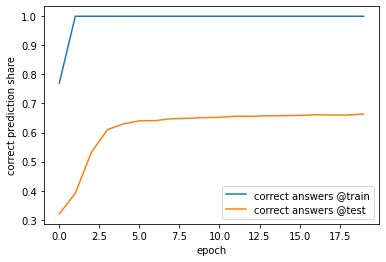

model: Dense
Label: О. Генри   74% the model recognized as О. Генри correct prediction
Label: Стругацкие 72% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   37% the model recognized as Булгаков correct prediction
Label: Саймак     54% the model recognized as Саймак   correct prediction
Label: Фрай       82% the model recognized as Фрай     correct prediction
Label: Брэдберри  67% the model recognized as Брэдберриcorrect prediction

average prediction rate: 66 %
Epoch 1/20
138/138 [==============================] - 4s 21ms/step - loss: 0.7028 - accuracy: 0.7764 - val_loss: 1.6576 - val_accuracy: 0.3542
Epoch 2/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 1.3855 - val_accuracy: 0.4477
Epoch 3/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.1367 - val_accuracy: 0.5721
Epoch 4/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0018 

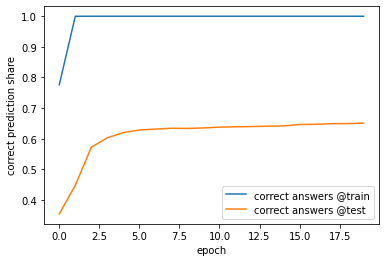

model: Dense
Label: О. Генри   90% the model recognized as О. Генри correct prediction
Label: Стругацкие 68% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   38% the model recognized as Булгаков correct prediction
Label: Саймак     48% the model recognized as Саймак   correct prediction
Label: Фрай       77% the model recognized as Фрай     correct prediction
Label: Брэдберри  66% the model recognized as Брэдберриcorrect prediction

average prediction rate: 65 %
Epoch 1/20
138/138 [==============================] - 4s 21ms/step - loss: 0.6364 - accuracy: 0.7941 - val_loss: 1.7595 - val_accuracy: 0.3599
Epoch 2/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0060 - accuracy: 0.9999 - val_loss: 1.5658 - val_accuracy: 0.4150
Epoch 3/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.3912 - val_accuracy: 0.4632
Epoch 4/20
138/138 [==============================] - 3s 20ms/step - loss: 0.0016 

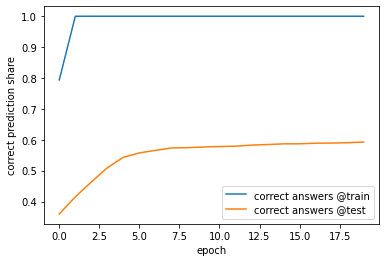

model: Dense
Label: О. Генри   91% the model recognized as О. Генри correct prediction
Label: Стругацкие 61% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   24% the model recognized as О. Генри false prediction
Label: Саймак     32% the model recognized as Стругацкиеfalse prediction
Label: Фрай       79% the model recognized as Фрай     correct prediction
Label: Брэдберри  59% the model recognized as Брэдберриcorrect prediction

average prediction rate: 59 %
{10: 0.6637750523481902, 50: 0.6506132216571942, 200: 0.5925815136105295}


In [37]:
maxWordsCount = 50000

# DATA PROCESSING

tokenizer = Tokenizer(
    num_words = maxWordsCount, # max words to be processed by the model
    filters = symbolsToFilter,
    lower = True, # enforce the lower register
    split = ' ', # split by space
    oov_token = 'unknown', # replaces all out-of-vocabulary words
    char_level = False # if True, every charcter is used as token
)

tokenizer.fit_on_texts(trainText)

trainWordIndices = tokenizer.texts_to_sequences(trainText)
testWordIndices = tokenizer.texts_to_sequences(testText)

xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)


# MODEL FIT

embedDim = [10, 50, 200]
globHist = {}

for d in embedDim:
    modelE = Sequential()
    modelE.add(Embedding(maxWordsCount, 20, input_length=xLen))
    modelE.add(Dropout(0.2))
    modelE.add(Flatten())
    modelE.add(BatchNormalization())
    modelE.add(Dense(200, activation='relu'))
    modelE.add(Dropout(0.2))
    modelE.add(BatchNormalization())
    modelE.add(Dense(6, activation='sigmoid'))

    modelE.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = modelE.fit(
        xTrain, yTrain,
        epochs = 20,
        batch_size = 128,
        validation_data = (xTest, yTest)
    )

    plt.plot(history.history['accuracy'], label='correct answers @train')
    plt.plot(history.history['val_accuracy'], label='correct answers @test')
    plt.xlabel('epoch')
    plt.ylabel('correct prediction share')
    plt.legend()
    plt.show()

    # PREDICTION

    xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
    pred = recognizeMultiLabels(modelE, xTestLabels, 'Dense')
    globHist[d] = pred

print(globHist)

In [38]:
print(globHist)

{10: 0.6637750523481902, 50: 0.6506132216571942, 200: 0.5925815136105295}


The score profit is negligible.

In some case the score of the model can be raised with the text preprocessing step. Let's test other samples lengths and steps:

Epoch 1/20
273/273 [==============================] - 5s 11ms/step - loss: 0.0410 - accuracy: 0.9872 - val_loss: 0.1919 - val_accuracy: 0.9536
Epoch 2/20
273/273 [==============================] - 2s 9ms/step - loss: 3.9482e-04 - accuracy: 1.0000 - val_loss: 0.1513 - val_accuracy: 0.9501
Epoch 3/20
273/273 [==============================] - 2s 9ms/step - loss: 1.9128e-04 - accuracy: 1.0000 - val_loss: 0.1406 - val_accuracy: 0.9559
Epoch 4/20
273/273 [==============================] - 2s 9ms/step - loss: 1.1206e-04 - accuracy: 1.0000 - val_loss: 0.1336 - val_accuracy: 0.9606
Epoch 5/20
273/273 [==============================] - 2s 9ms/step - loss: 8.4702e-05 - accuracy: 1.0000 - val_loss: 0.1341 - val_accuracy: 0.9614
Epoch 6/20
273/273 [==============================] - 2s 9ms/step - loss: 6.0274e-05 - accuracy: 1.0000 - val_loss: 0.1271 - val_accuracy: 0.9603
Epoch 7/20
273/273 [==============================] - 2s 9ms/step - loss: 4.3342e-05 - accuracy: 1.0000 - val_loss: 0.1274 - va

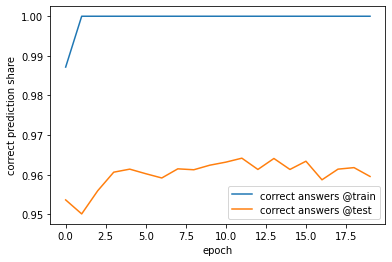

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 91% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   92% the model recognized as Булгаков correct prediction
Label: Саймак     99% the model recognized as Саймак   correct prediction
Label: Фрай       95% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 95 %
Epoch 1/20
137/137 [==============================] - 2s 11ms/step - loss: 0.0873 - accuracy: 0.9721 - val_loss: 0.3330 - val_accuracy: 0.9459
Epoch 2/20
137/137 [==============================] - 1s 9ms/step - loss: 9.7530e-04 - accuracy: 1.0000 - val_loss: 0.1910 - val_accuracy: 0.9550
Epoch 3/20
137/137 [==============================] - 1s 9ms/step - loss: 4.7707e-04 - accuracy: 1.0000 - val_loss: 0.1568 - val_accuracy: 0.9557
Epoch 4/20
137/137 [==============================] - 1s 8ms/step - loss: 3

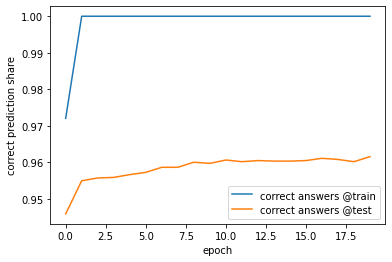

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 96% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   96% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
91/91 [==============================] - 2s 11ms/step - loss: 0.1165 - accuracy: 0.9619 - val_loss: 0.4557 - val_accuracy: 0.9428
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2631 - val_accuracy: 0.9578
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 7.2076e-04 - accuracy: 1.0000 - val_loss: 0.1872 - val_accuracy: 0.9578
Epoch 4/20
91/91 [==============================] - 1s 8ms/step - loss: 4.9996e-04 - 

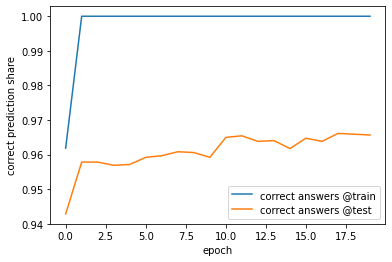

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   97% the model recognized as Булгаков correct prediction
Label: Саймак     99% the model recognized as Саймак   correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
69/69 [==============================] - 1s 12ms/step - loss: 0.1608 - accuracy: 0.9459 - val_loss: 0.5046 - val_accuracy: 0.9281
Epoch 2/20
69/69 [==============================] - 1s 9ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3284 - val_accuracy: 0.9585
Epoch 3/20
69/69 [==============================] - 1s 9ms/step - loss: 9.5928e-04 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9597
Epoch 4/20
69/69 [==============================] - 1s 9ms/step - loss: 6.7395e-04 - 

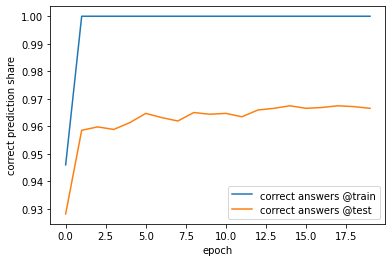

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 93% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   98% the model recognized as Булгаков correct prediction
Label: Саймак     99% the model recognized as Саймак   correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
55/55 [==============================] - 1s 12ms/step - loss: 0.2041 - accuracy: 0.9354 - val_loss: 0.6707 - val_accuracy: 0.7964
Epoch 2/20
55/55 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4075 - val_accuracy: 0.9197
Epoch 3/20
55/55 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2873 - val_accuracy: 0.9608
Epoch 4/20
55/55 [==============================] - 0s 9ms/step - loss: 8.0031e-04 - accu

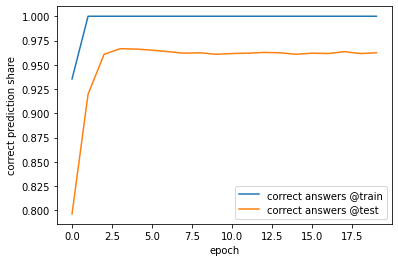

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 98% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   95% the model recognized as Булгаков correct prediction
Label: Саймак     99% the model recognized as Саймак   correct prediction
Label: Фрай       90% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
46/46 [==============================] - 1s 13ms/step - loss: 0.2386 - accuracy: 0.9241 - val_loss: 0.6452 - val_accuracy: 0.9083
Epoch 2/20
46/46 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4625 - val_accuracy: 0.9466
Epoch 3/20
46/46 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3498 - val_accuracy: 0.9558
Epoch 4/20
46/46 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy

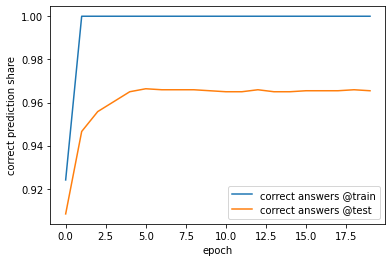

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 89% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   99% the model recognized as Булгаков correct prediction
Label: Саймак     99% the model recognized as Саймак   correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
39/39 [==============================] - 1s 14ms/step - loss: 0.2791 - accuracy: 0.9088 - val_loss: 0.6576 - val_accuracy: 0.9140
Epoch 2/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4812 - val_accuracy: 0.9484
Epoch 3/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3798 - val_accuracy: 0.9532
Epoch 4/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0013 - accuracy

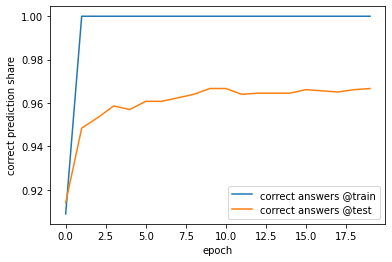

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 94% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   98% the model recognized as Булгаков correct prediction
Label: Саймак     99% the model recognized as Саймак   correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
35/35 [==============================] - 1s 14ms/step - loss: 0.3135 - accuracy: 0.8947 - val_loss: 0.8618 - val_accuracy: 0.6493
Epoch 2/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5649 - val_accuracy: 0.8661
Epoch 3/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4242 - val_accuracy: 0.9459
Epoch 4/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy

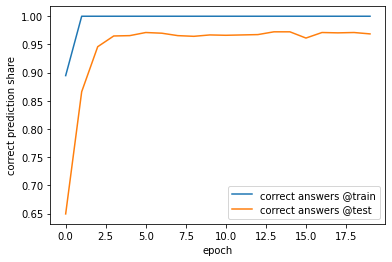

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 99% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   95% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
31/31 [==============================] - 1s 15ms/step - loss: 0.3745 - accuracy: 0.8761 - val_loss: 0.7947 - val_accuracy: 0.8330
Epoch 2/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.6027 - val_accuracy: 0.8951
Epoch 3/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4903 - val_accuracy: 0.9220
Epoch 4/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy

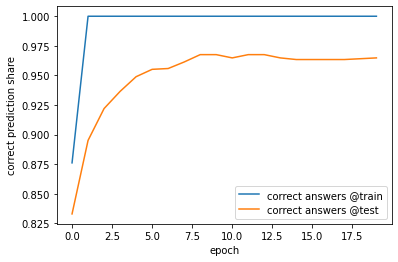

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 92% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   98% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
272/272 [==============================] - 4s 11ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.1403 - val_accuracy: 0.9822
Epoch 2/20
272/272 [==============================] - 2s 9ms/step - loss: 3.8655e-04 - accuracy: 1.0000 - val_loss: 0.0991 - val_accuracy: 0.9814
Epoch 3/20
272/272 [==============================] - 2s 9ms/step - loss: 1.8153e-04 - accuracy: 1.0000 - val_loss: 0.0904 - val_accuracy: 0.9819
Epoch 4/20
272/272 [==============================] - 2s 9ms/step - loss: 1

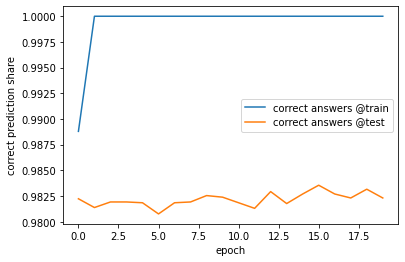

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 99% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 98 %
Epoch 1/20
136/136 [==============================] - 2s 11ms/step - loss: 0.0705 - accuracy: 0.9775 - val_loss: 0.3060 - val_accuracy: 0.9713
Epoch 2/20
136/136 [==============================] - 1s 9ms/step - loss: 8.6429e-04 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9733
Epoch 3/20
136/136 [==============================] - 1s 9ms/step - loss: 4.5850e-04 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 0.9721
Epoch 4/20
136/136 [==============================] - 1s 9ms/step - loss: 2

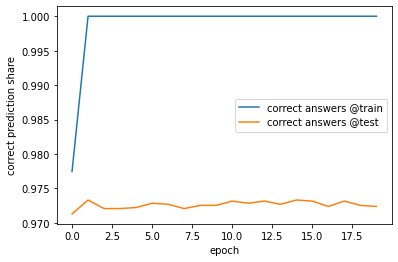

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 95% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   99% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
91/91 [==============================] - 2s 12ms/step - loss: 0.1038 - accuracy: 0.9666 - val_loss: 0.4428 - val_accuracy: 0.9193
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2428 - val_accuracy: 0.9560
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 6.3121e-04 - accuracy: 1.0000 - val_loss: 0.1666 - val_accuracy: 0.9691
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 4.4505e-04 - 

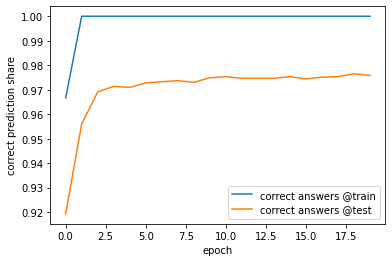

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 98% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   99% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
68/68 [==============================] - 1s 12ms/step - loss: 0.1449 - accuracy: 0.9525 - val_loss: 0.5201 - val_accuracy: 0.9187
Epoch 2/20
68/68 [==============================] - 1s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3339 - val_accuracy: 0.9553
Epoch 3/20
68/68 [==============================] - 1s 9ms/step - loss: 9.7523e-04 - accuracy: 1.0000 - val_loss: 0.2342 - val_accuracy: 0.9625
Epoch 4/20
68/68 [==============================] - 1s 9ms/step - loss: 7.5095e-04 - 

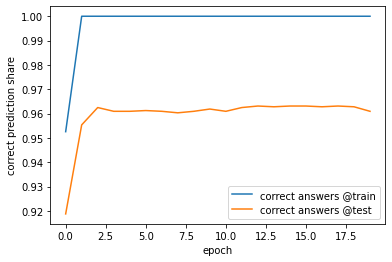

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 91% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   98% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
55/55 [==============================] - 2s 19ms/step - loss: 0.1739 - accuracy: 0.9415 - val_loss: 0.5794 - val_accuracy: 0.8406
Epoch 2/20
55/55 [==============================] - 1s 9ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3769 - val_accuracy: 0.9341
Epoch 3/20
55/55 [==============================] - 1s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2694 - val_accuracy: 0.9504
Epoch 4/20
55/55 [==============================] - 0s 9ms/step - loss: 7.5109e-04 - accu

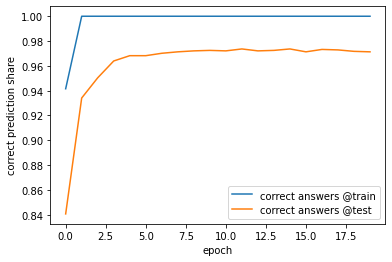

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 99% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   96% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
46/46 [==============================] - 1s 13ms/step - loss: 0.2089 - accuracy: 0.9305 - val_loss: 0.6502 - val_accuracy: 0.8735
Epoch 2/20
46/46 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4350 - val_accuracy: 0.9317
Epoch 3/20
46/46 [==============================] - 0s 9ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3191 - val_accuracy: 0.9507
Epoch 4/20
46/46 [==============================] - 0s 9ms/step - loss: 9.1731e-04 - accu

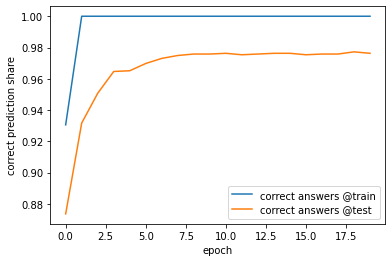

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 96% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   99% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
39/39 [==============================] - 1s 14ms/step - loss: 0.2515 - accuracy: 0.9180 - val_loss: 0.6834 - val_accuracy: 0.7976
Epoch 2/20
39/39 [==============================] - 0s 10ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4779 - val_accuracy: 0.9295
Epoch 3/20
39/39 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3572 - val_accuracy: 0.9609
Epoch 4/20
39/39 [==============================] - 0s 10ms/step - loss: 0.0013 - accur

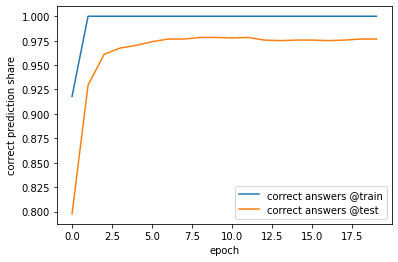

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 96% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       93% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
35/35 [==============================] - 1s 14ms/step - loss: 0.2963 - accuracy: 0.9033 - val_loss: 0.7336 - val_accuracy: 0.7367
Epoch 2/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.5309 - val_accuracy: 0.9095
Epoch 3/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.4041 - val_accuracy: 0.9523
Epoch 4/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy

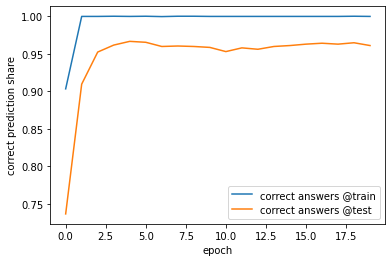

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 85% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
31/31 [==============================] - 1s 15ms/step - loss: 0.2973 - accuracy: 0.9051 - val_loss: 0.7015 - val_accuracy: 0.8481
Epoch 2/20
31/31 [==============================] - 0s 10ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.5051 - val_accuracy: 0.9289
Epoch 3/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.4112 - val_accuracy: 0.9408
Epoch 4/20
31/31 [==============================] - 0s 9ms/step - loss: 0.0011 - accurac

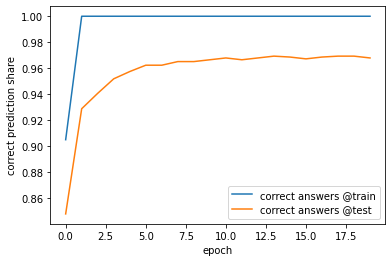

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 87% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   99% the model recognized as Булгаков correct prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       96% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
269/269 [==============================] - 3s 10ms/step - loss: 0.0279 - accuracy: 0.9915 - val_loss: 0.1337 - val_accuracy: 0.9578
Epoch 2/20
269/269 [==============================] - 2s 9ms/step - loss: 3.2211e-04 - accuracy: 1.0000 - val_loss: 0.0973 - val_accuracy: 0.9629
Epoch 3/20
269/269 [==============================] - 2s 9ms/step - loss: 1.5855e-04 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9652
Epoch 4/20
269/269 [==============================] - 2s 9ms/step - loss: 9

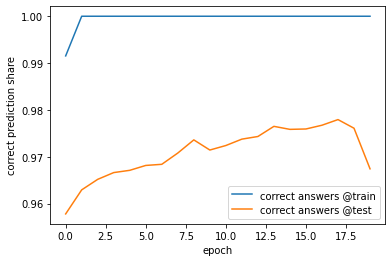

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 90% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
135/135 [==============================] - 2s 12ms/step - loss: 0.0566 - accuracy: 0.9827 - val_loss: 0.2768 - val_accuracy: 0.9625
Epoch 2/20
135/135 [==============================] - 1s 9ms/step - loss: 7.0564e-04 - accuracy: 1.0000 - val_loss: 0.1532 - val_accuracy: 0.9756
Epoch 3/20
135/135 [==============================] - 1s 9ms/step - loss: 3.9359e-04 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy: 0.9740
Epoch 4/20
135/135 [==============================] - 2s 15ms/step - loss: 

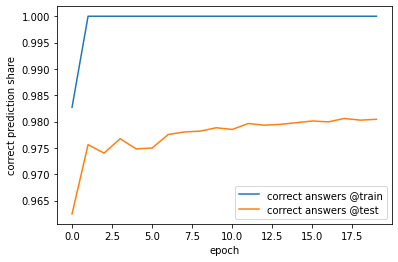

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 97% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       94% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 98 %
Epoch 1/20
90/90 [==============================] - 2s 12ms/step - loss: 0.0825 - accuracy: 0.9743 - val_loss: 0.3533 - val_accuracy: 0.9485
Epoch 2/20
90/90 [==============================] - 1s 9ms/step - loss: 9.7997e-04 - accuracy: 1.0000 - val_loss: 0.1863 - val_accuracy: 0.9690
Epoch 3/20
90/90 [==============================] - 1s 9ms/step - loss: 5.8944e-04 - accuracy: 1.0000 - val_loss: 0.1158 - val_accuracy: 0.9764
Epoch 4/20
90/90 [==============================] - 1s 9ms/step - loss: 4.1034e-0

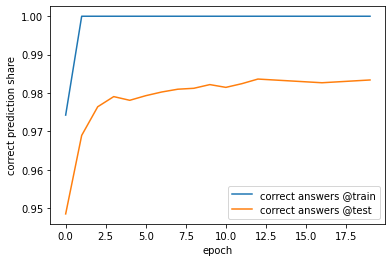

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 98% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       95% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 98 %
Epoch 1/20
68/68 [==============================] - 1s 12ms/step - loss: 0.1021 - accuracy: 0.9692 - val_loss: 0.4379 - val_accuracy: 0.9385
Epoch 2/20
68/68 [==============================] - 1s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9817
Epoch 3/20
68/68 [==============================] - 1s 9ms/step - loss: 8.5947e-04 - accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9821
Epoch 4/20
68/68 [==============================] - 1s 9ms/step - loss: 5.4356e-04 - 

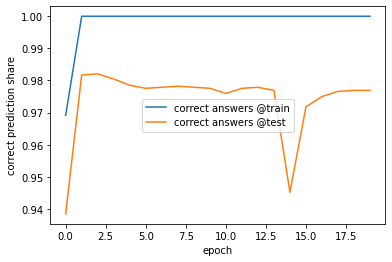

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 100% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1356 - accuracy: 0.9552 - val_loss: 0.5783 - val_accuracy: 0.8132
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3277 - val_accuracy: 0.9463
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2155 - val_accuracy: 0.9655
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 7.5216e-04 - acc

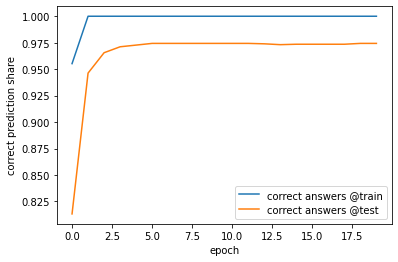

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 99% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       91% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
45/45 [==============================] - 1s 14ms/step - loss: 0.1769 - accuracy: 0.9459 - val_loss: 0.4927 - val_accuracy: 0.9808
Epoch 2/20
45/45 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3381 - val_accuracy: 0.9889
Epoch 3/20
45/45 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2431 - val_accuracy: 0.9870
Epoch 4/20
45/45 [==============================] - 0s 10ms/step - loss: 8.3208e-04 - acc

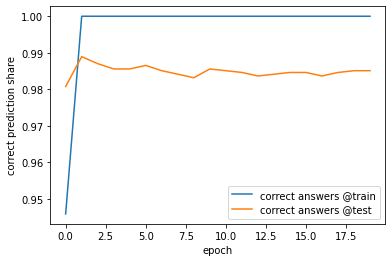

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 100% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       95% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 98 %
Epoch 1/20
39/39 [==============================] - 1s 14ms/step - loss: 0.1758 - accuracy: 0.9453 - val_loss: 0.5421 - val_accuracy: 0.9063
Epoch 2/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3756 - val_accuracy: 0.9361
Epoch 3/20
39/39 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2805 - val_accuracy: 0.9484
Epoch 4/20
39/39 [==============================] - 0s 9ms/step - loss: 8.9876e-04 - acc

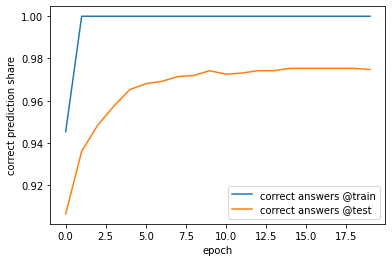

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 98% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 97 %
Epoch 1/20
34/34 [==============================] - 1s 15ms/step - loss: 0.2261 - accuracy: 0.9240 - val_loss: 0.6295 - val_accuracy: 0.9295
Epoch 2/20
34/34 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.4443 - val_accuracy: 0.9513
Epoch 3/20
34/34 [==============================] - 0s 12ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3395 - val_accuracy: 0.9584
Epoch 4/20
34/34 [==============================] - 0s 9ms/step - loss: 0.0013 - accurac

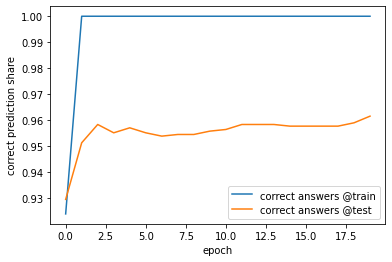

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 90% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       92% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 96 %
Epoch 1/20
30/30 [==============================] - 1s 15ms/step - loss: 0.2478 - accuracy: 0.9202 - val_loss: 0.6672 - val_accuracy: 0.9251
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4559 - val_accuracy: 0.9582
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3494 - val_accuracy: 0.9626
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0011 - accur

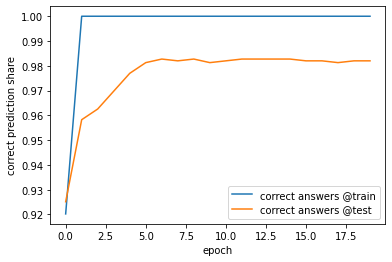

model: Dense
Label: О. Генри   100% the model recognized as О. Генриcorrect prediction
Label: Стругацкие 95% the model recognized as Стругацкиеcorrect prediction
Label: Булгаков   100% the model recognized as Булгаковcorrect prediction
Label: Саймак     100% the model recognized as Саймак  correct prediction
Label: Фрай       96% the model recognized as Фрай     correct prediction
Label: Брэдберри  100% the model recognized as Брэдберриcorrect prediction

average prediction rate: 98 %
{(4000, 50): 0.9595602367955716, (4000, 100): 0.9615739317553028, (4000, 150): 0.9656523743660673, (4000, 200): 0.9665027658266748, (4000, 250): 0.9623511333077218, (4000, 300): 0.965453707968678, (4000, 350): 0.9666666666666667, (4000, 400): 0.9686732186732187, (4000, 450): 0.9648033126293996, (5000, 50): 0.9823077519981377, (5000, 100): 0.972385975798945, (5000, 150): 0.9758026989297348, (5000, 200): 0.9609181141439206, (5000, 250): 0.9713067080263668, (5000, 300): 0.9762900976290098, (5000, 350): 0.976

In [16]:
maxWordsCounts = 10000

paramDict = {
    'xLens' : [4000, 5000, 8500],
    'steps' : range(50, 500, 50)
} 

globHist = {}

for xLen in paramDict['xLens']:
    for step in paramDict['steps']:

        # DATA PROCESSING

        tokenizer = Tokenizer(
            num_words = maxWordsCount, # max words to be processed by the model
            filters = symbolsToFilter,
            lower = True, # enforce the lower register
            split = ' ', # split by space
            oov_token = 'unknown', # replaces all out-of-vocabulary words
            char_level = False # if True, every charcter is used as token
        )

        tokenizer.fit_on_texts(trainText)

        trainWordIndices = tokenizer.texts_to_sequences(trainText)
        testWordIndices = tokenizer.texts_to_sequences(testText)

        xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
        xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)

        xTrainB = tokenizer.sequences_to_matrix(xTrain.tolist())
        xTestB = tokenizer.sequences_to_matrix(xTest.tolist())

        # MODEL FIT

        modelD = Sequential()
        modelD.add(Dense(200, input_dim = maxWordsCount, activation='sigmoid'))
        modelD.add(Dropout(0.25))
        modelD.add(Dense(200, activation='sigmoid'))
        modelD.add(Dropout(0.25))
        modelD.add(BatchNormalization())
        modelD.add(Dense(nLabels, activation='softmax'))

        modelD.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = modelD.fit(
            xTrainB,
            yTrain,
            epochs=20,
            batch_size=128,
            validation_data = (xTestB, yTest)
        )

        plt.plot(history.history['accuracy'], label='correct answers @train')
        plt.plot(history.history['val_accuracy'], label='correct answers @test')
        plt.xlabel('epoch')
        plt.ylabel('correct prediction share')
        plt.legend()
        plt.show()

        # PREDICTION

        xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
        pred = recognizeMultiLabels(modelD, xTestLabelsB, 'Dense')

        globHist[(xLen, step)] = pred

print(globHist)

As the result we have several parameters combinations that allow to boost score above 97%:

In [19]:
{k: v for k, v in globHist.items() if v >= 0.97}

{(5000, 50): 0.9823077519981377,
 (5000, 100): 0.972385975798945,
 (5000, 150): 0.9758026989297348,
 (5000, 250): 0.9713067080263668,
 (5000, 300): 0.9762900976290098,
 (5000, 350): 0.9766684753119913,
 (8500, 100): 0.9804361770365619,
 (8500, 150): 0.9834054834054834,
 (8500, 200): 0.9769230769230769,
 (8500, 250): 0.9743486973947896,
 (8500, 300): 0.9851033157135992,
 (8500, 350): 0.9747616376892877,
 (8500, 450): 0.9820014398848093}